## Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import warnings
import datetime as dt

warnings.filterwarnings("ignore")


## Load and preprocess data

In [ ]:
# Load tweet data
tweet_data = pd.read_csv('stock_tweets.csv')
print(f"Total tweets: {tweet_data.shape[0]}")

# Select tweets for a specific stock (Amazon in this case)
target_stock = 'AMZN'
amzn_tweets = tweet_data[tweet_data['Stock Name'] == target_stock]
print(f"Amazon tweets: {amzn_tweets.shape[0]}")

# Convert the datetime to date for daily aggregation
amzn_tweets['Date'] = pd.to_datetime(amzn_tweets['Date']).dt.date

Total tweets: 80793
Amazon tweets: 4089


## Perform sentiment analysis

In [ ]:
df = amzn_tweets.copy()

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

# Function to get sentiment scores
def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU if available
    outputs = model(**inputs)
    scores = outputs.logits[0].tolist()

    # Calculate Compound Score
    sum_s = sum(scores)
    sum_s_squared = sum([s**2 for s in scores])
    alpha = 1e-6  # Small constant to avoid division by zero
    compound_score = sum_s * (1 / (sum_s_squared + alpha)**0.5)

    return compound_score

# Apply sentiment analysis to each tweet
tqdm.pandas()
df['sentiment_score'] = df['Tweet'].progress_apply(get_sentiment_score)

# Calculate daily sentiment scores
daily_sentiment = df.groupby('Date')['sentiment_score'].mean().reset_index()

# Save results
daily_sentiment.to_csv('daily_sentiment_scores.csv', index=False)

print(daily_sentiment.head())
print(daily_sentiment.shape)

100%|██████████| 4089/4089 [00:50<00:00, 80.92it/s] 

         Date  sentiment_score
0  2021-09-30         0.146071
1  2021-10-01         0.056817
2  2021-10-02         0.216049
3  2021-10-03         0.121344
4  2021-10-04         0.173246
(365, 2)


## Load and preprocess stock data

In [ ]:
# Load stock data
stock_data = pd.read_csv('stock_yfinance_data.csv')
amzn_stock_data = stock_data[stock_data['Stock Name'] == target_stock].copy()
amzn_stock_data['Date'] = pd.to_datetime(amzn_stock_data['Date']).dt.date
print(f"amzn stock data shape: {amzn_stock_data.shape}")

# Calculate technical indicators
def calculate_ema(data, period):
    """Calculate Exponential Moving Average"""
    return data.ewm(span=period, adjust=False).mean()

def calculate_macd(data, fast, slow, signal):
    """Calculate MACD (Moving Average Convergence Divergence)"""
    fast_ema = calculate_ema(data, fast)
    slow_ema = calculate_ema(data, slow)
    macd = fast_ema - slow_ema
    signal_line = calculate_ema(macd, signal)
    return macd - signal_line

def calculate_rsi(data, period):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr(high, low, close, period):
    """Calculate Average True Range"""
    tr = np.maximum(high - low, np.abs(high - close.shift(1)), np.abs(low - close.shift(1)))
    return tr.rolling(window=period).mean()

def calculate_bollinger_bands(data, period, num_std=2):
    """Calculate Bollinger Bands"""
    sma = data.rolling(window=period).mean()
    std = data.rolling(window=period).std()
    upper = sma + (std * num_std)
    lower = sma - (std * num_std)
    return upper, lower

# Calculate technical indicators
amzn_stock_data['pct_change'] = amzn_stock_data['Close'].pct_change()
amzn_stock_data['log_change'] = np.log(amzn_stock_data['Close'] / amzn_stock_data['Close'].shift(1))
amzn_stock_data['ema_7'] = calculate_ema(amzn_stock_data['Close'], 7)
amzn_stock_data['ema_14'] = calculate_ema(amzn_stock_data['Close'], 14)
amzn_stock_data['macd_7'] = calculate_macd(amzn_stock_data['Close'], 3, 11, 7)
amzn_stock_data['rsi_7'] = calculate_rsi(amzn_stock_data['Close'], 7)
amzn_stock_data['rsi_14'] = calculate_rsi(amzn_stock_data['Close'], 14)
amzn_stock_data['atr_7'] = calculate_atr(amzn_stock_data['High'], amzn_stock_data['Low'], amzn_stock_data['Close'], 7)
amzn_stock_data['atr_14'] = calculate_atr(amzn_stock_data['High'], amzn_stock_data['Low'], amzn_stock_data['Close'], 14)
amzn_stock_data['upper_7'], amzn_stock_data['lower_7'] = calculate_bollinger_bands(amzn_stock_data['Close'], 7)
amzn_stock_data['upper_14'], amzn_stock_data['lower_14'] = calculate_bollinger_bands(amzn_stock_data['Close'], 14)

# Drop NA values
amzn_stock_data = amzn_stock_data.dropna()

print(amzn_stock_data.head())


amzn stock data shape: (252, 8)
            Date        Open        High         Low       Close   Adj Close  \
1022  2021-10-20  172.632996  173.143005  170.018494  170.753006  170.753006   
1023  2021-10-21  170.712494  172.014008  170.149994  171.750504  171.750504   
1024  2021-10-22  171.050003  171.492004  166.565002  166.777496  166.777496   
1025  2021-10-25  166.750000  167.389999  164.884995  166.018494  166.018494   
1026  2021-10-26  167.475494  170.806000  167.199005  168.803497  168.803497   

        Volume Stock Name  pct_change  log_change  ...      ema_14    macd_7  \
1022  42796000       AMZN   -0.008446   -0.008482  ...  167.036258  0.849722   
1023  37628000       AMZN    0.005842    0.005825  ...  167.664824  0.451246   
1024  62782000       AMZN   -0.028955   -0.029382  ...  167.546513 -1.167547   
1025  44520000       AMZN   -0.004551   -0.004561  ...  167.342777 -1.752615   
1026  53966000       AMZN    0.016775    0.016636  ...  167.537540 -0.970240   

      

## Visualize technical indicators

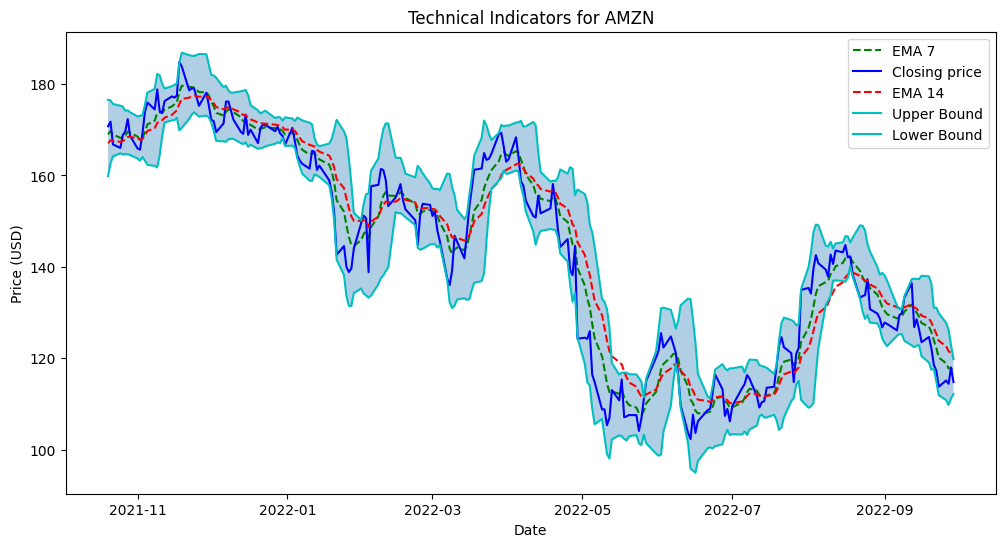

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(amzn_stock_data['Date'], amzn_stock_data['ema_7'], label='EMA 7', color='g', linestyle='--')
plt.plot(amzn_stock_data['Date'], amzn_stock_data['Close'], label='Closing price', color='b')
plt.plot(amzn_stock_data['Date'], amzn_stock_data['ema_14'], label='EMA 14', color='r', linestyle='--')
plt.plot(amzn_stock_data['Date'], amzn_stock_data['upper_7'], label='Upper Bound', color='c')
plt.plot(amzn_stock_data['Date'], amzn_stock_data['lower_7'], label='Lower Bound', color='c')
plt.fill_between(amzn_stock_data['Date'], amzn_stock_data['lower_7'], amzn_stock_data['upper_7'], alpha=0.35)
plt.title(f'Technical Indicators for {target_stock}')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.show()

## Perform Fourier Transform analysis

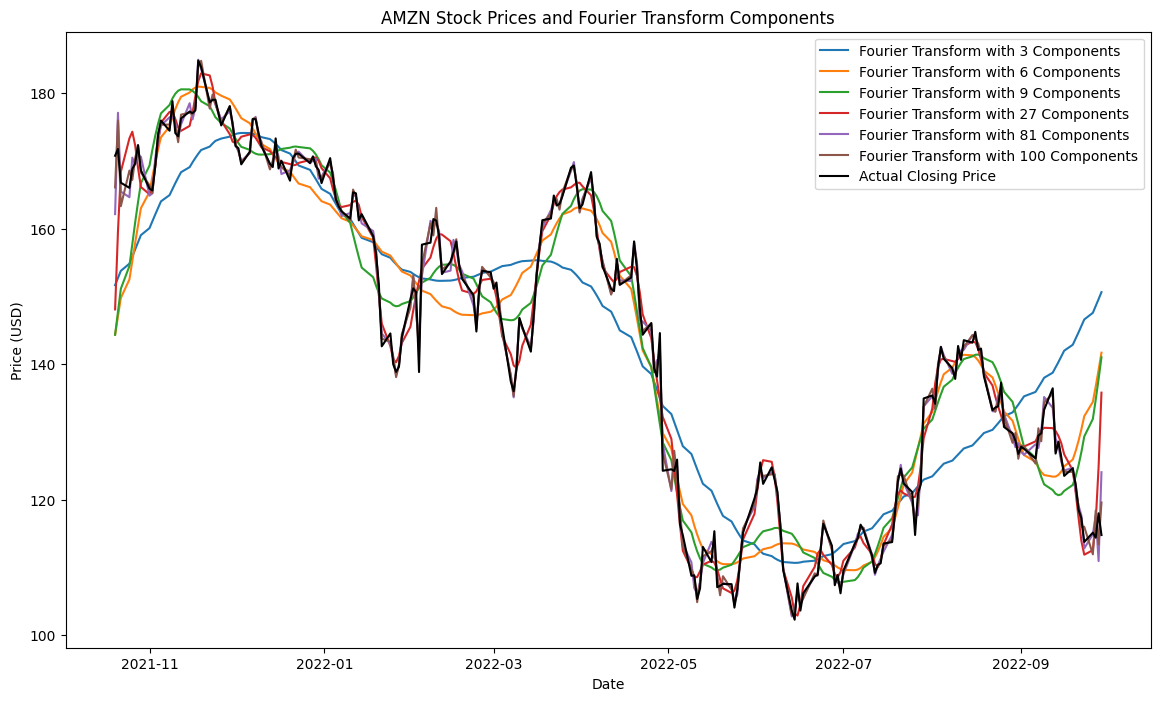

In [ ]:
# Applying Fourier Transform to the closing prices
fft_result = np.fft.fft(np.asarray(amzn_stock_data['Close'].tolist()))
fft_df = pd.DataFrame({'fft': fft_result})
fft_df['magnitude'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['phase'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plotting Fourier Transform components
plt.figure(figsize=(14, 8))
fft_values = np.asarray(fft_df['fft'].tolist())
for component in [3, 6, 9, 27, 81, 100]:
    fft_component = np.copy(fft_values)
    fft_component[component:-component] = 0
    amzn_stock_data[f'FT_{component}_components'] = np.fft.ifft(fft_component).real
    plt.plot(amzn_stock_data['Date'], amzn_stock_data[f'FT_{component}_components'], label=f'Fourier Transform with {component} Components')

plt.plot(amzn_stock_data['Date'], amzn_stock_data['Close'], label='Actual Closing Price', color='black')
plt.title(f'{target_stock} Stock Prices and Fourier Transform Components')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Combine stock data with sentiment scores

In [ ]:
# Join Stock data with sentiment scores
combined_data = amzn_stock_data.merge(daily_sentiment, on='Date', how='left')

combined_data['target'] = combined_data['Close']
combined_data = combined_data.drop(columns=['Stock Name'])

print(combined_data.head())
print(combined_data.info())

# Save the processed data
combined_data.to_csv('processed_amzn_data.csv', index=False)

         Date        Open        High         Low       Close   Adj Close  \
0  2021-10-20  172.632996  173.143005  170.018494  170.753006  170.753006   
1  2021-10-21  170.712494  172.014008  170.149994  171.750504  171.750504   
2  2021-10-22  171.050003  171.492004  166.565002  166.777496  166.777496   
3  2021-10-25  166.750000  167.389999  164.884995  166.018494  166.018494   
4  2021-10-26  167.475494  170.806000  167.199005  168.803497  168.803497   

     Volume  pct_change  log_change       ema_7  ...    upper_14    lower_14  \
0  42796000   -0.008446   -0.008482  169.000023  ...  173.920676  157.078184   
1  37628000    0.005842    0.005825  169.687643  ...  175.048387  157.034403   
2  62782000   -0.028955   -0.029382  168.960107  ...  174.742141  158.381863   
3  44520000   -0.004551   -0.004561  168.224703  ...  174.474319  159.359470   
4  53966000    0.016775    0.016636  168.369402  ...  174.605288  160.043215   

   FT_3_components  FT_6_components  FT_9_components  FT